In [1]:
# import valid libaries
import matplotlib.pyplot as plt
import matplotlib.pyplot as py
import numpy as np
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim
import gdsfactory.simulation.modes as gm
import meep as mp
import sys
from datetime import datetime
import scipy
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import math
import os
import csv
import time


2023-02-11 16:19:06.831 | INFO     | gdsfactory.config:<module>:50 - Load '/home/sgears/mambaforge/envs/mp/lib/python3.11/site-packages/gdsfactory' 6.27.0
2023-02-11 16:19:07.354 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/sgears/mambaforge/envs/mp/lib/python3.11/site-packages/gdsfactory/generic_tech/klayout/tech/layers.lyp.
/home/sgears/mambaforge/envs/mp/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-11 16:19:07.648 | INFO     | gdsfactory.simulation.gmeep:<module>:34 - Meep '1.25.0-beta' installed at ['/home/sgears/mambaforge/envs/mp/lib/python3.11/site-packages/meep']


/tmp/ipykernel_1978/1332054591.py:79: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax0.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_1978/1332054591.py:80: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax0.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_1978/1332054591.py:81: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax0.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_1978/1332054591.py:97: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_1978/1332054591.py:98: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotl

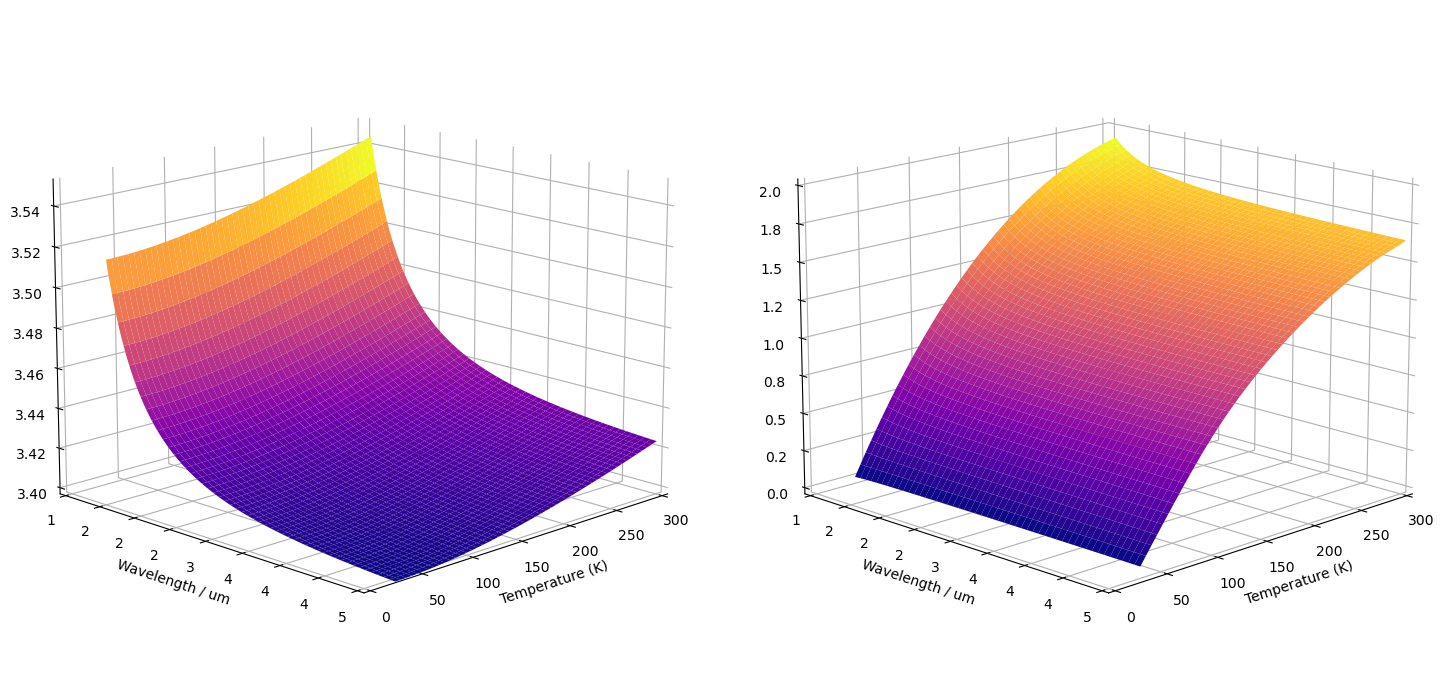

In [2]:

def s(S, T):
    return S[0]+S[1]*T+S[2]*T**2+S[3]*T**3+S[4]*T**4

def l(L, T):
    return L[0]+L[1]*T+L[2]*T**2+L[3]*T**3+L[4]*T**4

def index(lam, T, S1, S2, S3, L1, L2, L3):
    return np.sqrt(((s(S1, T)*lam**2)/(lam**2-l(L1, T)**2))+((s(S2, T)*lam**2)/(lam**2-l(L2, T)**2))+((s(S3, T)*lam**2)/(lam**2-l(L3, T)**2))+1)

# Extract fit params from the paper in forms of lists 

S1_si = [10.4907, -2.08020e-04, 4.21694e-06, -5.82298e-09, 3.44688e-12]
S2_si = [-1346.61, 29.1664, -0.278724, 1.05939e-03, -1.35089e-06]
S3_si = [4.42827e7, -1.76213e6, -7.61575e4, 678.414, 103.243]
L1_si = [0.299713, -1.14234e-5, 1.67134e-7, -2.51049e-10, 2.32484e-14]
L2_si = [-3.51710e3, 42.3892, -0.357957, 1.17504e-3, -1.13212e-6]
L3_si = [1.71400e6, -1.44984e5, -6,90744e3, -39.3699, 23.5770]

# Do the same thing for the Silica from this paper: https://arxiv.org/pdf/0805.0091.pdf

# Uses corning fused silica, should be fine, check with AMF data at 295K



S1_sio2 = [1.10127, -4.94251e-5, 5.27414e-7, -1.59700e-9, 1.75949e-12]
S2_sio2 = [1.78752e-5, 4.76391e-5, -4.49019e-7, 1.44546e-9, -1.57223e-12]
S3_sio2 = [7.93552e-1, -1.27815e-3,  1.84595e-5, -9.20275e-8, 1.48829e-10]
L1_sio2 = [-8.90600e-2, 9.08730e-6, -6.53638e-8, 7.77072e-11, 6.84605E-14]
L2_sio2 = [2.97562e-1, -8.59578e-4, 6.59069e-6, -1.09482e-8, 7.85145e-13]
L3_sio2 = [9.34454, -7.09788e-3, 1.01968e-4, -5.07660e-7, 8.21348E-10]

data_points = 1000
wls_fit_si = np.linspace(1.1, 5, data_points)
wls_fit_sio2 = np.linspace(0.4, 2.6, data_points)

ts = np.linspace(30, 300, data_points)
refs_si = []
refs_sio2 = []

for i in range(len(wls_fit_si)):
    refs_si.append(index(wls_fit_si[i], ts, S1_si, S2_si, S3_si, L1_si, L2_si, L3_si))
    refs_sio2.append(index(wls_fit_sio2[i], ts, S1_sio2, S2_sio2, S3_sio2, L1_sio2, L2_sio2, L3_sio2))


refs_si = np.array(refs_si)
refs_sio2 = np.array(refs_sio2)

dx = ts[1]-ts[0]
dndts_si = []
dndts_sio2 = []

for i in range(0, len(refs_si)):
    y = refs_si[i]
    dy = np.diff(y)/dx
    dndts_si.append(dy/1e-4)
    y = refs_sio2[i]
    dy = np.diff(y)/dx
    dndts_sio2.append(dy/1e-6)

# first stage
# calculate refractive indecies for Si and SiO2 for 2um using Dom's code
cm = 1
dndts_si = np.array(dndts_si)
dndts_sio2 = np.array(dndts_sio2)
c=299792458


n = 1
fig = plt.figure(figsize = (14.5*cm, 8*cm))

ax0 = fig.add_subplot(121, projection = '3d')
ax0.zaxis._axinfo['juggled'] = (1,2,0)

ax1 = fig.add_subplot(122, projection = '3d')
ax1.zaxis._axinfo['juggled'] = (1,2,0)

X, Y = np.meshgrid(wls_fit_si, ts)                     

ax0.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax0.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax0.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax0.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax0.zaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax0.set_xlim(1, 5)
ax0.set_ylim(0, 300)
ax0.set_zlim(3.4, 3.55)
ax0.set_xlabel('Wavelength / um')
ax0.set_ylabel('Temperature (K)')
ax0.set_zlabel('n')

ax0.plot_surface(X, Y, refs_si.T, cmap='plasma', shade = True, antialiased=True, linewidth = 0)
ax0.view_init(15, -45)

X, Y = np.meshgrid(wls_fit_si, ts[n:])                    

ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax1.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax1.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax1.zaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax1.set_xlim(1, 5)
ax1.set_ylim(0, 300)
ax1.set_zlim(0, 2)
ax1.set_xlabel('Wavelength / um')
ax1.set_ylabel('Temperature (K)')
# ax1.set_zlabel('$\\text{dn/dT}\\ \\times\\text{10}^{\\text{-4}} (\\text{K}^\\text{-1})$', rotation = 20)
ax1.set_zlabel(' ', rotation = 90)

ax1.plot_surface(X, Y, dndts_si.T[n-1:], cmap='plasma', shade = True, antialiased=True, linewidth = 0)
ax1.view_init(15, -45)
ax1.set_ylim(0, 300)

fig.tight_layout(w_pad = 5)

plt.show()

# i wish dom discovered commenting
def get_si_si02_n(wavelength_lambda,desired_temp=300):

    n_lambda_si = 0
    n_lambda_sio2 = 0


    index_lambda_si = np.argmin(abs(wls_fit_si-wavelength_lambda))

    index_temp_si = np.argmin(abs(ts-desired_temp))

    index_lambda_sio2 = np.argmin(abs(wls_fit_sio2-wavelength_lambda))

    index_temp_sio2 = np.argmin(abs(ts-desired_temp))

    n_lambda_si = refs_si[index_lambda_si][index_temp_si]
    n_lambda_sio2 = refs_sio2[index_lambda_sio2][index_temp_si]
    
    return [n_lambda_si,n_lambda_sio2]

In [3]:
# calculate effective indexes around desired wavelength centre_lambda
# lets simulate the CORN05 edge coupled source
def get_n_eff(n_lambda_si,n_lambda_sio2,centre_lambda,mode,mask_nl,side_angles=15,wg_width= 0.51,wg_thickness=0.34,resolution=100,sz=3,sy=3):

    refractive_eff_index = np.zeros(mode)
    ratio_nl_s = np.zeros(mode)
    
    # find lower wavelength effective index
    modes = gm.find_modes_waveguide(
        wg_width= wg_width,
        wavelength=centre_lambda,
        ncore=n_lambda_si,
        nclad=n_lambda_sio2,
        wg_thickness=wg_thickness,
        resolution=resolution,
        sz=sz,
        sy=sy,
        nmodes=mode,
        sidewall_angle=side_angles,
    )
    #sample_plot = modes[2]
    #sample_plot.plot_eps()
    # get refractive index for n modes
    for i in range(mode):
        refractive_eff_index[i] = modes[i+1].neff
        #modes[mode].plot_e_all()
        #modes[mode].plot_h_all()
        E = modes[i+1].E
        H = modes[i+1].H
        # calculate cross product of two matricies E and H, where E each has shape (300,300,1,3) and the last dimension corresponds to axis
        cross_product = np.cross(E,H)  # Calculate cross product of two matrices E and H
        cross_product_z = cross_product[:,:,:,0]
        cross_product_z = cross_product_z[:,:,0]

        sz_nl = np.sum((np.multiply(cross_product_z,mask_nl)))
        sz_all = np.sum((cross_product_z))
        ratio_nl_s[i] = sz_all/sz_nl
        #print('Ratio nl integrals : ',ratio_nl_s)
        #print('L integral',sz_all)
        #print('NL integral',sz_nl)

        #py.figure()
        #y = E[:,:,:,2]
        #py.imshow(np.multiply(y[:,:,0],mask_nl))

    return refractive_eff_index,ratio_nl_s

In [4]:
# frequency lambda conversions
def lambda_omega_conversion(parameter):
    return 2 * np.pi * 299792458 / parameter

In [5]:
def next_factor2357(n):
    def is_factor2357(n):
        def divby(n, p):
            return divby(n // p, p) if n % p == 0 else n

        return divby(divby(divby(divby(n, 2), 3), 5), 7) == 1

    if is_factor2357(n):
        return n
    return next_factor2357(n + 1)

In [6]:
def get_neff_aeff(mode,side_angles,wg_thickness,wg_width,resolution,sy_base,waveguide_temperature,start_wavelength,end_wavelength,w_k_sweep_steps):
    # mode solved datapoints
    # simulation structure parameters
    u = 1E-6

    sy = next_factor2357(np.ceil((sy_base * np.sqrt(wg_width/0.51)*10)))/10
    sz = sy

    # convert these values to frequency
    start_frequency = lambda_omega_conversion(start_wavelength)
    end_frequency = lambda_omega_conversion(end_wavelength)
    sample_frequencys = np.linspace(start_frequency,end_frequency,w_k_sweep_steps)
    sample_wavelengths = lambda_omega_conversion(sample_frequencys)

    # final effective indecies and effective areas
    sample_eff_indexes = np.zeros([w_k_sweep_steps,mode])
    sample_a_eff = np.zeros([w_k_sweep_steps,mode])

    # calculate the nonlinear area
    # top length
    wg_top_width = wg_width - 2 * math.tan(math.radians(side_angles))*wg_thickness
    area_nl = 0.5*(wg_width+wg_top_width)*wg_thickness

    # calculate integration bounds by creating a mesh
    z_bound = int(sz * resolution)
    y_bound = int(sy * resolution)
    mask_nl = np.zeros([y_bound,z_bound])
    # find the start index for each y slice
    y_0 = (sy-wg_thickness)/2
    z_0 = (sz-wg_top_width)/2
    for i in range(z_bound):
        current_z = i / resolution
        if ( current_z > z_0):
            if ( current_z < (z_0 + wg_thickness)):
                # fill in shape with 1's
                min_y = y_0 - (z_0+wg_thickness-current_z)*math.tan(math.radians(side_angles))
                max_y = y_0 + wg_top_width + (z_0+wg_thickness-current_z)*math.tan(math.radians(side_angles))
                min_y_index = int(min_y*resolution)
                max_y_index = int(max_y*resolution)
                mask_nl[min_y_index:max_y_index,i]=1
    #py.imshow(mask_nl)

    for index, wavelength in enumerate(sample_wavelengths):
        # convert wavelength to um
        print('Starting Wavelength '+str(index)+'/'+str(w_k_sweep_steps))
        wg_start_time = time.time()
        wavelength = wavelength / u

        # get absolute indecies
        eff_indexes = get_si_si02_n(wavelength,desired_temp=waveguide_temperature)
        # get effective indecies
        n_eff_out,a_eff_out = get_n_eff(eff_indexes[0],eff_indexes[1],wavelength,mode,mask_nl,side_angles=side_angles,wg_width=wg_width,wg_thickness=wg_thickness,resolution=resolution,sz=sz,sy=sy)
        # put into arrays
        sample_eff_indexes[index,:] = n_eff_out
        sample_a_eff[index,:] = a_eff_out*area_nl
        wg_end_time = time.time()
        elapsed_time = wg_end_time - wg_start_time
        print('Finished Wavelength '+str(index)+'/'+str(w_k_sweep_steps) + ' in ' + str(elapsed_time) + 's')

    return sample_wavelengths,sample_eff_indexes,sample_a_eff

In [7]:
u = 1E-6

# fixed geometry parameters
mode = 2
side_angles = 2
wg_thickness = 0.22
waveguide_temperature = 300

# simulation parameters
resolution = 60
sy_base = 3

# wavelength w k sweep parameters
start_wavelength = 1.8 * u
end_wavelength = 2.2 * u
w_k_sweep_steps = 100

# sweeping waveguide width, in um
wg_initial_width = 0.5
wg_final_width = 2
wg_width_sweep_steps = 15
# make a dictionary of everything
metadata = {
    'mode':str(mode),
    'side_angles':str(side_angles),
    'wg_thickness':str(wg_thickness),
    'waveguide_temperature':str(waveguide_temperature),
    'resolution':str(resolution),
    'sy_base':str(sy_base),
    'start_wavelength':str(start_wavelength),
    'end_wavelength':str(end_wavelength),
    'w_k_sweep_steps':str(w_k_sweep_steps),
    'wg_initial_width':str(wg_initial_width),
    'wg_final_width':str(wg_final_width),
    'wg_width_sweep_steps':str(wg_width_sweep_steps),
    }

# put this into a huge csv file
folder_name = 'waveguide_width_sweeps_mode_'+str(mode)+'_resolution_'+str(resolution)+'_sybase'+str(sy_base)+'_wg_initial_width'+str(wg_initial_width)+'_wg_final_width'+str(wg_final_width)+'_w_k_sweep_steps'+str(w_k_sweep_steps)
os.mkdir(folder_name)

# put everything in a header csv file
file_header = folder_name+'/header.csv'
file = open(file_header, "w")

# write metadata to header file
writer = csv.writer(file)
for key, value in metadata.items():
    writer.writerow([key, value])
file.close()

# start doing waveguide width sweeps
widths = np.linspace(wg_initial_width,wg_final_width,wg_width_sweep_steps)

for index_width, wg_width in enumerate(widths):
    start_time_width = time.time()
    print('Starting Width '+str(index_width)+'/'+str(wg_width_sweep_steps))
    sample_wavelengths,sample_eff_indexes,sample_a_eff = get_neff_aeff(mode,side_angles,wg_thickness,wg_width,resolution,sy_base,waveguide_temperature,start_wavelength,end_wavelength,w_k_sweep_steps)
    # write to file
    print('Writing to csv...')
    file_name = folder_name +'/' + str(wg_width) + '.csv'
    with open(file_name, 'w', newline='') as outcsv:
        writer = csv.writer(outcsv)
        writer.writerow(["Wavelength", "mode" , "n_eff", "a_eff / um^2"])
        for i in range(w_k_sweep_steps):
            for j in range(mode):
                writer.writerow([sample_wavelengths[i], str(j) , sample_eff_indexes[i,j],sample_a_eff[i,j]])
    print('CSV Written')
    end_time_width = time.time()
    print('Finished Width '+str(index_width)+'/'+str(wg_width_sweep_steps) + ' in ' + str((end_time_width-start_time_width)) + 's')


print('Everything Finished!!')

Starting Width 0/15
Starting Wavelength 0/100
epsilon: 2.07739-11.9944, mean 2.19691, harm. mean 2.09974, 100% > 1, 1.20521% "fill"
epsilon: 2.07739-11.9944, mean 2.19691, harm. mean 2.09974, 100% > 1, 1.20521% "fill"
Finished Wavelength 0/100 in 10.180375576019287s
Starting Wavelength 1/100


/home/sgears/mambaforge/envs/mp/lib/python3.11/site-packages/gdsfactory/types.py:215: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(val, dtype=cls.inner_type)


epsilon: 2.07731-11.993, mean 2.19681, harm. mean 2.09965, 100% > 1, 1.20521% "fill"
epsilon: 2.07731-11.993, mean 2.19681, harm. mean 2.09965, 100% > 1, 1.20521% "fill"
Finished Wavelength 1/100 in 10.751758337020874s
Starting Wavelength 2/100
epsilon: 2.07714-11.9916, mean 2.19663, harm. mean 2.09948, 100% > 1, 1.20521% "fill"
epsilon: 2.07714-11.9916, mean 2.19663, harm. mean 2.09948, 100% > 1, 1.20521% "fill"
Finished Wavelength 2/100 in 10.590893268585205s
Starting Wavelength 3/100
epsilon: 2.07705-11.9902, mean 2.19652, harm. mean 2.09939, 100% > 1, 1.20521% "fill"
epsilon: 2.07705-11.9902, mean 2.19652, harm. mean 2.09939, 100% > 1, 1.20521% "fill"
Finished Wavelength 3/100 in 10.661110401153564s
Starting Wavelength 4/100
epsilon: 2.07688-11.9888, mean 2.19634, harm. mean 2.09922, 100% > 1, 1.20521% "fill"
epsilon: 2.07688-11.9888, mean 2.19634, harm. mean 2.09922, 100% > 1, 1.20521% "fill"
Finished Wavelength 4/100 in 10.583139181137085s
Starting Wavelength 5/100
epsilon: 2.076

SystemError: <built-in function mode_solver_solve_kpoint> returned a result with an exception set